# Biweekly Report 5

# Jake Watts

# Transfer Learning with Frozen Layers

In this section of the report I continue to experiment with transfer learning. However this time I also freeze the earlier layers of the network while training to see if that helps to improve model performance. I chose to freeze the early layers in the network as my hypothesis is that those layers will be the most generalizable to other object classification tasks. Then I compare the results with the results in the first notebook. 

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Conv2D, Add
from tensorflow.keras.layers import SeparableConv2D, ReLU, ELU
from tensorflow.keras.layers import BatchNormalization, MaxPool2D
from tensorflow.keras.layers import GlobalAvgPool2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Model
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from google.colab import drive
import numpy as np

Loading data.

In [ ]:
(train, test), info = tfds.load('svhn_cropped', 
                        split = ['train', 'test'],
                        with_info = True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/svhn_cropped/3.0.0.incompleteC1DPPL/svhn_cropped-train.tfrecord


  0%|          | 0/73257 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/svhn_cropped/3.0.0.incompleteC1DPPL/svhn_cropped-test.tfrecord


  0%|          | 0/26032 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/svhn_cropped/3.0.0.incompleteC1DPPL/svhn_cropped-extra.tfrecord


  0%|          | 0/531131 [00:00<?, ? examples/s]

Dataset svhn_cropped downloaded and prepared to /root/tensorflow_datasets/svhn_cropped/3.0.0. Subsequent calls will reuse this data.


Loading model.

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
model = load_model('/content/gdrive/My Drive/cifar10_xception_aug.h5')

Here is a look at the layers in the model.

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 16, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 16, 16, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
elu (ELU)                       (None, 16, 16, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

I chose to freeze the first 5 layers in the model.

In [ ]:
for i in range(5):
  model.layers[i+1].trainable = False

Checking to make sure the appropriate layers are frozen.

In [ ]:
for i in range(len(model.layers)):
  print(i, model.layers[i].trainable)

0 True
1 False
2 False
3 False
4 False
5 False
6 True
7 True
8 True
9 True
10 True
11 True
12 True
13 True
14 True
15 True
16 True
17 True
18 True
19 True
20 True
21 True
22 True
23 True
24 True
25 True
26 True
27 True
28 True
29 True
30 True
31 True
32 True
33 True
34 True
35 True
36 True
37 True
38 True
39 True
40 True
41 True
42 True
43 True
44 True
45 True
46 True
47 True
48 True


Functions to process data are the same as in the previous notebook.

In [ ]:
def normalize_img(datapoint):
  input_image = tf.cast(datapoint['image'], tf.float32) / 255.0
  input_label = tf.one_hot(datapoint['label'], 10)
  return input_image, input_label

In [ ]:
train_img = train.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
test_img = test.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [ ]:
train_batches = (
    train_img
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_img.batch(BATCH_SIZE)

In [ ]:
filepath = '/content/gdrive/My Drive/svhn_xception_tl_freeze1.h5'

checkpoint = ModelCheckpoint(filepath=filepath,
                             verbose=1,
                             save_best_only=True)
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)
es = EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=5)

callbacks = [checkpoint, lr_reducer, es]

Compiling and training the model.

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=callbacks)

Epoch 1/20
1144/1144 [==============================] - 18s 14ms/step - loss: 0.5784 - accuracy: 0.8257 - val_loss: 0.3111 - val_accuracy: 0.9103

Epoch 00001: val_loss improved from inf to 0.31106, saving model to /content/gdrive/My Drive/svhn_xception_tl_freeze1.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
1144/1144 [==============================] - 16s 14ms/step - loss: 0.2443 - accuracy: 0.9274 - val_loss: 0.2827 - val_accuracy: 0.9186

Epoch 00002: val_loss improved from 0.31106 to 0.28266, saving model to /content/gdrive/My Drive/svhn_xception_tl_freeze1.h5
Epoch 3/20
1144/1144 [==============================] - 16s 14ms/step - loss: 0.1640 - accuracy: 0.9522 - val_loss: 0.2758 - val_accuracy: 0.9234

Epoch 00003: val_loss improved from 0.28266 to 0.27581, saving model to /content/gdrive/My Drive/svhn_xception_tl_freeze1.h5
Epoch 4/20
1144/1144 [==============================] - 16s 14ms/step - loss: 0.1074 - accuracy: 0.9697 - val_loss: 0.2752 - val_accuracy: 0.9290

Epoch 00004: val_loss improved from 0.27581 to 0.27519, saving model to /content/gdrive/My Drive/svhn_xception_tl_freeze1.h5
Epoch 5/20
1144/1144 [==============================] - 16s 14ms/step - loss: 0.0684 - accuracy: 0.9801 - val_loss: 0.3028 - val_accuracy: 0.9250

Epoch 00005: val_loss did not improve

The plot below shows the training history. After the first epoch the model has a high validation accuracy but it does not really improve after more training while the training accuracy reaches 100% very quickly.

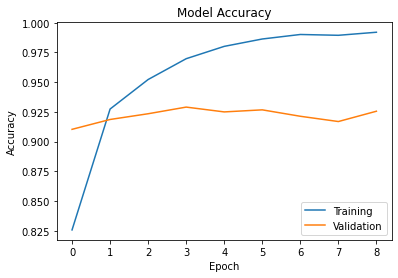

In [ ]:
plt.figure()
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

The test accuracy of the trained model is 92.68% which is higher than the accuracy using pre-trained weights without freezing which was 91.31%. 

In [ ]:
model.evaluate(test_batches)

407/407 [==============================] - 5s 12ms/step - loss: 0.3671 - accuracy: 0.9268


[0.3670637011528015, 0.9268208146095276]

Based on the accuracy plot I also wanted to train the model in the same way but with a decreased learning rate in the hopes that the model will not reach 100% so quickly.

In [ ]:
model = load_model('/content/gdrive/My Drive/cifar10_xception_aug.h5')

In [ ]:
for i in range(5):
  model.layers[i+1].trainable = False

In [ ]:
filepath = '/content/gdrive/My Drive/svhn_xception_tl_freeze1.h5'

checkpoint = ModelCheckpoint(filepath=filepath,
                             verbose=1,
                             save_best_only=True)
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)
es = EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=5)

callbacks = [checkpoint, lr_reducer, es]

Compiling the model with a learning rate of .0001 rather than .001.

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(1e-4), metrics=['accuracy'])

In [ ]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=callbacks)

Epoch 1/20
1144/1144 [==============================] - 68s 14ms/step - loss: 1.6542 - accuracy: 0.5237 - val_loss: 0.8762 - val_accuracy: 0.7230

Epoch 00001: val_loss improved from inf to 0.87622, saving model to /content/gdrive/My Drive/svhn_xception_tl_freeze1.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
1144/1144 [==============================] - 16s 14ms/step - loss: 0.6619 - accuracy: 0.7887 - val_loss: 0.5749 - val_accuracy: 0.8181

Epoch 00002: val_loss improved from 0.87622 to 0.57489, saving model to /content/gdrive/My Drive/svhn_xception_tl_freeze1.h5
Epoch 3/20
1144/1144 [==============================] - 16s 14ms/step - loss: 0.4795 - accuracy: 0.8498 - val_loss: 0.4575 - val_accuracy: 0.8549

Epoch 00003: val_loss improved from 0.57489 to 0.45746, saving model to /content/gdrive/My Drive/svhn_xception_tl_freeze1.h5
Epoch 4/20
1144/1144 [==============================] - 16s 14ms/step - loss: 0.3846 - accuracy: 0.8815 - val_loss: 0.3965 - val_accuracy: 0.8785

Epoch 00004: val_loss improved from 0.45746 to 0.39653, saving model to /content/gdrive/My Drive/svhn_xception_tl_freeze1.h5
Epoch 5/20
1144/1144 [==============================] - 16s 14ms/step - loss: 0.3249 - accuracy: 0.9012 - val_loss: 0.3615 - val_accuracy: 0.8902

Epoch 00005: val_loss improved from 0

Training the model with a lower rate keeps the training accuracy fom hitting 100% quickly, however the validation accuracy appears to plateau just above 90%/

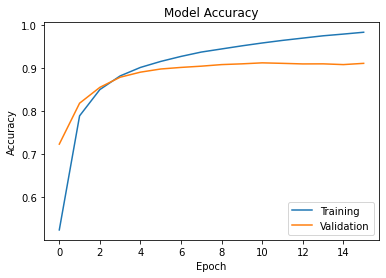

In [ ]:
plt.figure()
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

The accuracy with this lower learning rate is lower than with the increased accuracy rate and required many more epochs to reach a higher accuracy.

In [ ]:
model.evaluate(test_batches)

407/407 [==============================] - 5s 12ms/step - loss: 0.3483 - accuracy: 0.9104


[0.34832051396369934, 0.9103795289993286]

# Summary

In summary, freezing layers from the pre-trained model did have an accuracy 1% higher than a pre-trained model with no untrainable layers. This may be because freezing the layers allowed the model to utilize the learned techniques in the first few layers. This method also reached a fairly high level of accuracy in fewer epochs than training with no transfer learning.

Overall transfer learning in this case appears useful for getting a good model with little training time, however it still appears that training without transfer learning performs better likely because the data is very different. Perhaps a model trained on MNIST data would do a better job at transfer learning since the type of data would be more similar.